In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Importing functions from the modules in the qseg package
from qseg.graph_utils import image_to_grid_graph, draw, draw_graph_cut_edges
from qseg.utils import decode_binary_string

# Additional necessary imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_optimization.applications import Maxcut
import dimod
from dwave.samplers import SimulatedAnnealingSampler
import time
import cv2

In [3]:
def simulated_annealing_solver(G, n_samples):
    """
    Solve the Maxcut problem on graph G using Simulated Annealing.

    Parameters:
    G (networkx.Graph): Graph for which Maxcut is to be solved.
    n_samples (int): Number of samples to collect.

    Returns:
    pandas.DataFrame: Dataframe containing samples.
    dict: Dictionary containing information about execution times.
    """
    start_time = time.time()
    w = -1 * nx.adjacency_matrix(G).todense()
    max_cut = Maxcut(w)
    qp = max_cut.to_quadratic_program()
    linear = qp.objective.linear.coefficients.toarray(order=None, out=None)
    quadratic = qp.objective.quadratic.coefficients.toarray(order=None, out=None)
    linear = {int(idx): -round(value, 2) for idx, value in enumerate(linear[0])}
    quadratic = {
        (int(iy), int(ix)): -quadratic[iy, ix]
        for iy, ix in np.ndindex(quadratic.shape)
        if iy < ix and abs(quadratic[iy, ix]) != 0
    }
    problem_formulation_time = time.time() - start_time

    # Solve using Simulated Annealing
    bqm = dimod.BinaryQuadraticModel(linear, quadratic, 0.0, dimod.BINARY)
    sampler = SimulatedAnnealingSampler()

    start_time = time.time()
    sampleset = sampler.sample(bqm, num_reads=n_samples)
    response_time = time.time() - start_time

    start_time = time.time()
    samples_df = sampleset.to_pandas_dataframe()
    sample_fetch_time = time.time() - start_time

    

    return samples_df

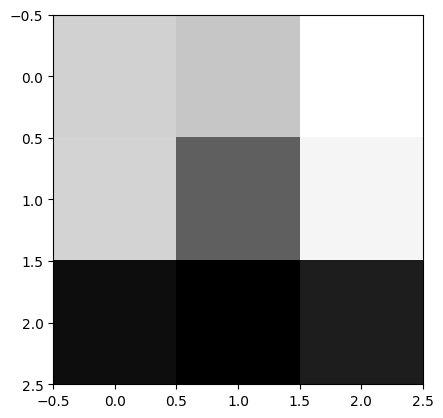

In [4]:


image = np.array([
    [0.82, 0.78, 0.99],
    [0.83, 0.40, 0.95],
    [0.1, 0.05, 0.16]
])
height, width = image.shape
plt.imshow(image, cmap=plt.cm.gray)

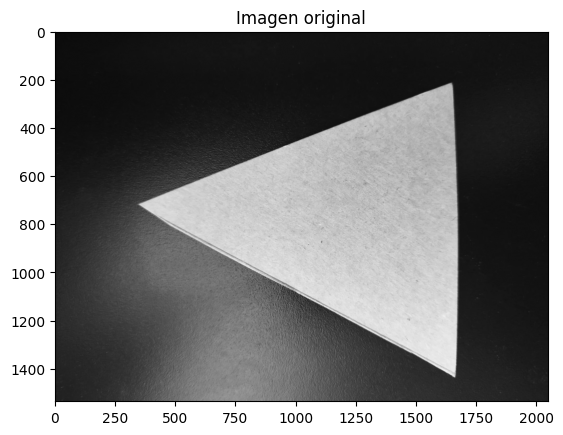

In [5]:
# Cargar imagen y convertir a escala de grises
#image_path = r"C:\Users\carlo\TFG\Q-Seg\triangulo.png"
image_path = r"C:\Users\carlo\TFG\Q-Seg\Negro.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#image = cv2.resize(image, (100, 100))  # Redimensionar para reducir el tamaño computacional
image = image / 255.0  # Normalizar valores entre 0 y 1
height, width = image.shape

plt.imshow(image, cmap='gray')
plt.title("Imagen original")
plt.show()

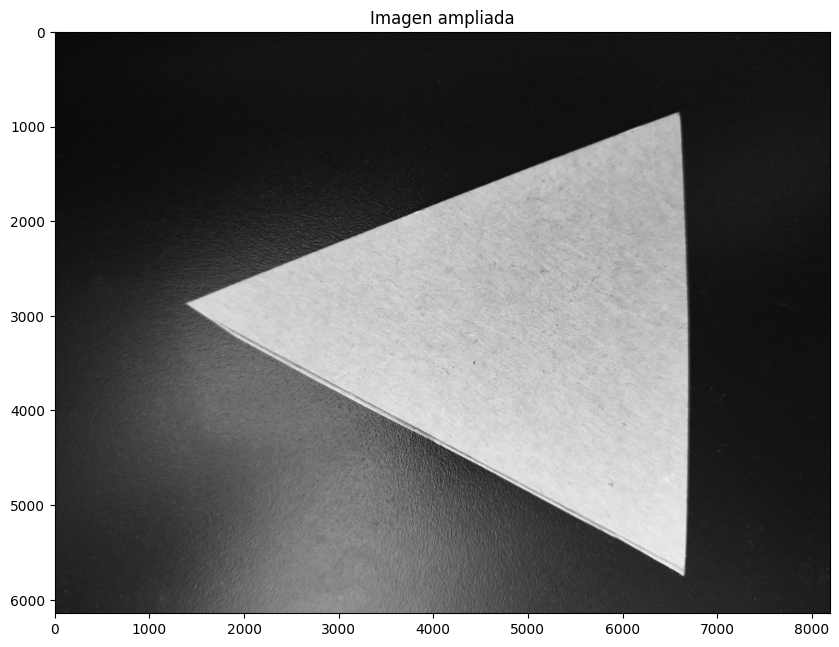

In [6]:
# Obtener dimensiones actuales
height, width = image.shape

# Aumentar tamaño de la imagen (doblar el tamaño en este caso)
scale_factor = 4  # Cambia este valor según el aumento deseado
image = cv2.resize(image, (width * scale_factor, height * scale_factor), interpolation=cv2.INTER_CUBIC)

# Mostrar la imagen ampliada
plt.figure(figsize=(10, 10))  # Ajustar tamaño de visualización
plt.imshow(image, cmap='gray')
plt.title("Imagen ampliada")
plt.show()



In [7]:
normalized_nx_elist = image_to_grid_graph(image)  # Using Gaussian similarity metric as edge weight metric
G = nx.grid_2d_graph(image.shape[0], image.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)
draw(G, image)


KeyboardInterrupt



In [ ]:

# Redimensionar la imagen antes de crear el grafo
target_size = (20, 20)  # Ajusta según necesites
image_resized = cv2.resize(image, target_size)

# Crear grafo con la imagen redimensionada
normalized_nx_elist = image_to_grid_graph(image_resized)  
G = nx.grid_2d_graph(image_resized.shape[0], image_resized.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)
height, width = image_resized.shape
draw(G, image_resized)


In [ ]:
samples_dataframe = simulated_annealing_solver(G, n_samples=2000)
print(samples_dataframe.columns)
# Mapear nodos (x, y) a índices enteros secuenciales
node_mapping = {node: i for i, node in enumerate(G.nodes)}

# Convertir la solución en una lista de enteros usando los índices correctos
solution_binary_string = [int(samples_dataframe.iloc[0][node_mapping[node]]) for node in G.nodes if node in node_mapping]

segmentation_mask = decode_binary_string(solution_binary_string, height, width)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)

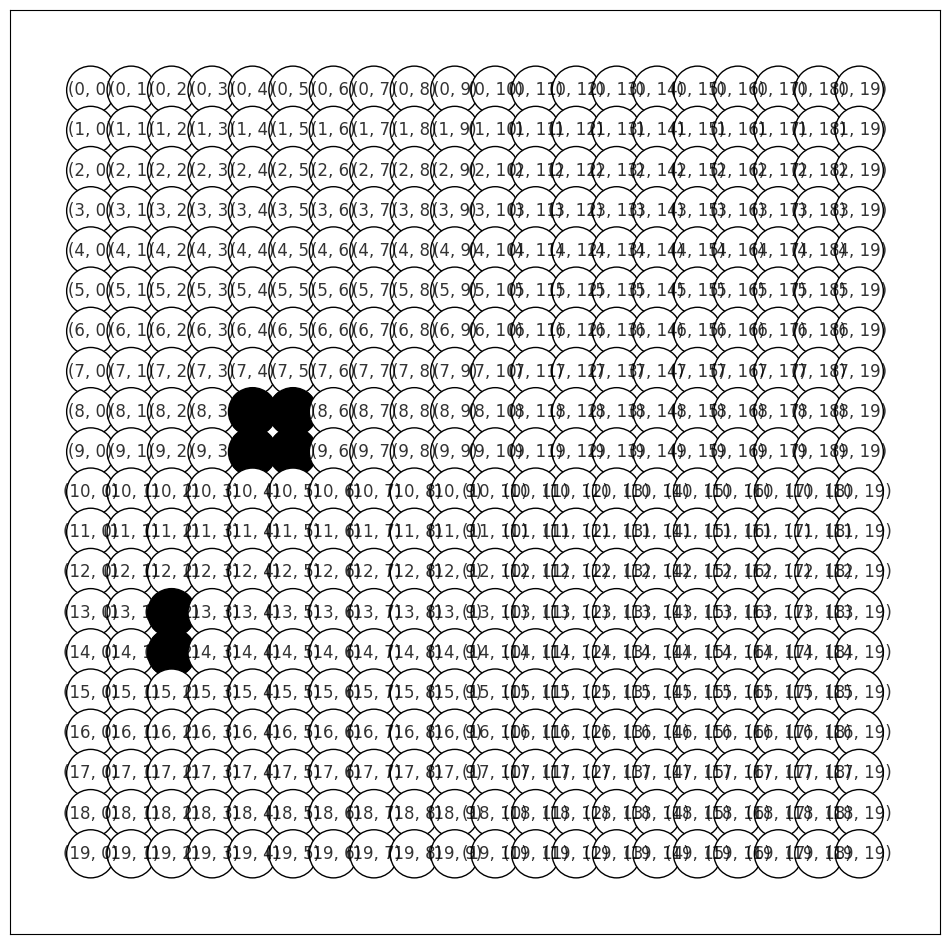

In [8]:
cut_edges = [(u, v) for (u, v, d) in G.edges(data=True) if segmentation_mask[u] != segmentation_mask[v]]
draw_graph_cut_edges(G, segmentation_mask, cut_edges)